In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import admm_fq_base as adf
import utils
import importlib
import seaborn as sns
import pickle


# import cvxpy
def getPart(index) -> int:
    return int(np.floor(index / part_len))



In [3]:
importlib.reload(adf)

<module 'admm_fq_base' from '/home/matthias/repos/asilomar2023/asilomar2023sim/src/admm_fq_base.py'>

In [4]:
rng = np.random.default_rng()

In [5]:
L = 4

In [6]:
nw = adf.Network(L, rng)
nw.addNode(0)
nw.addNode(1)
nw.addNode(2)
nw.setConnection(0, [1])
nw.setConnection(1, [2])
nw.setConnection(2, [0])

In [7]:
SNR = 20
SNR_c = np.inf
rho = 1
stepsize = 0.8
eta = 0.98
M = nw.N
nr_samples = 100000
partitions = 2
part_len = int(nr_samples / partitions)
runs = 20

In [8]:
def saveTransmissionHist(node1, node2, var_name, delta, var):
    if delta not in transmission_hist:
        transmission_hist[delta] = {}
    if var_name not in transmission_hist[delta]:
        transmission_hist[delta][var_name] = {}
    if node1 not in transmission_hist[delta][var_name]:
        transmission_hist[delta][var_name][node1] = {}
    if node2 not in transmission_hist[delta][var_name][node1]:
        transmission_hist[delta][var_name][node1][node2] = {}
    # transmission_hist[delta][var_name][node1][node2].append(var)
    d = np.concatenate([np.real(var), np.imag(var)])
    vals, counts = np.unique(d, return_counts=True)
    for i, val in enumerate(vals):
        if val not in transmission_hist[delta][var_name][node1][node2]:
            transmission_hist[delta][var_name][node1][node2][val] = 0
        transmission_hist[delta][var_name][node1][node2][val] += counts[i]
    pass

In [9]:
transmission_hist = {}
deltas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]
for run in range(runs):
    print("Run:", run)
    true_norms = [1.0, 1.0, 1.0, 1.0]

    u = rng.normal(size=(nr_samples, 1))
    clean_signal: np.ndarray = u / u.max()

    clean_signal = clean_signal / clean_signal.std(axis=0) * 0.25

    ## %%
    h = {}
    hf = {}
    noisy_signals = np.empty((0, M))
    for part in range(partitions):
        h_, hf_ = utils.generateRandomIRs(L, M, true_norms, rng)
        h[part] = h_
        hf[part] = hf_
        noisy_signals_ = utils.getNoisySignal(
            clean_signal[part * part_len : (part + 1) * part_len], h_, SNR, rng
        )
        noisy_signals = np.concatenate([noisy_signals, noisy_signals_])

    ## %%
    hopsize = L
    npm = []
    SNR_c_r = 10 ** (SNR_c / 20)
    nw.setOnTransmit(saveTransmissionHist)
    nw.reset()
    nw.setParameters(rho, stepsize, eta, 1, 0.0, 0)
    nw.setDeltas(deltas)
    for k_admm_fq in range(0, nr_samples - 2 * L, hopsize):
        nw.step(noisy_signals[k_admm_fq : k_admm_fq + 2 * L, :])
    #     error = []
    #     for m in range(M):
    #         node: adf.NodeProcessor = nw.nodes[m]
    #         error.append(
    #             utils.NPM(node.getEstimate(), hf[getPart(k_admm_fq)][:, m, None])
    #         )
    #     # npm.append(np.mean(error))
    #     npm.append(error)
    # npm = np.asarray(npm)

Run: 0


KeyboardInterrupt: 

In [9]:
with open("../data/transmission_hist.p", "wb") as f:
    pickle.dump(transmission_hist, f)

In [10]:
with open("../data/transmission_hist.p", "rb") as f:
    transmission_hist = pickle.load(f)

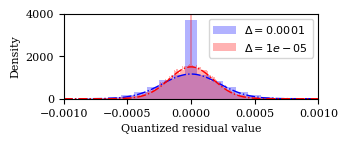

In [11]:
textwidth = 245
linewidth = 1.2
plt.rcParams.update(
    {
        "font.family": "serif",  # use serif/main font for text elements
        "text.usetex": False,  # don't use inline math for ticks (not on docker image)
        "pgf.rcfonts": False,  # don't setup fonts from rc parameters
        "font.size": 8,
    }
)
fig, ax = plt.subplots(figsize=utils.set_size(textwidth, 1.0, (1, 1), 0.4))
var = 0.00000005
delta = 0.0001
bins = np.asarray(list(transmission_hist[delta]["res_local_q"][1][0].keys()))
counts = np.asarray(list(transmission_hist[delta]["res_local_q"][1][0].values()))
density = counts / (sum(counts) * delta)
ax.bar(
    bins,
    density,
    width=delta,
    color="b",
    alpha=0.3,
    label=rf"$\Delta = {delta}$"
)
x = np.linspace(-10 * delta, 10 * delta, 100)
y = 1 / (np.sqrt(2 * np.pi * var)) * np.exp(-1 / 2 * x**2 / var)*0.65
ax.plot(x, y, "b-.", linewidth=1)

var = 0.00000003
delta = 0.00001
bins = np.asarray(list(transmission_hist[delta]["res_local_q"][1][0].keys()))
counts = np.asarray(list(transmission_hist[delta]["res_local_q"][1][0].values()))
density = counts / (sum(counts) * delta)
ax.bar(
    bins,
    density,
    width=delta,
    color="r",
    alpha=0.3,
    label=rf"$\Delta = {delta}$"
)
x = np.linspace(-100 * delta, 100 * delta, 100)
y = 1 / (np.sqrt(2 * np.pi * var)) * np.exp(-1 / 2 * x**2 / var)*0.65
ax.plot(x, y, "r-.", linewidth=1)

ax.set_xlim(-100 * delta, 100 * delta)
ax.set_ylim(0,4000)
# ax.grid()
ax.set_xlabel("Quantized residual value")
ax.set_ylabel("Density")
plt.tight_layout(pad=0.5)
plt.legend()
plt.show()
utils.savefig(fig, "dist-example", "pdf")

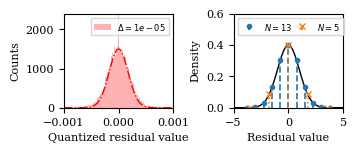

In [47]:
textwidth = 245
linewidth = 1.2
plt.rcParams.update(
    {
        "font.family": "serif",  # use serif/main font for text elements
        "text.usetex": False,  # don't use inline math for ticks (not on docker image)
        "pgf.rcfonts": False,  # don't setup fonts from rc parameters
        "font.size": 8,
    }
)
fig, axs = plt.subplots(1, 2, figsize=utils.set_size(textwidth, 1.0, (1, 1), 0.4))
# var = 0.00000005
# delta = 0.0001
# bins = np.asarray(list(transmission_hist[delta]["res_local_q"][1][0].keys()))
# counts = np.asarray(list(transmission_hist[delta]["res_local_q"][1][0].values()))
# density = counts / (sum(counts) * delta)
# axs[0].bar(
#     bins,
#     density,
#     width=delta,
#     color="b",
#     alpha=0.3,
#     label=rf"$\Delta = {delta}$"
# )
# x = np.linspace(-10 * delta, 10 * delta, 100)
# y = 1 / (np.sqrt(2 * np.pi * var)) * np.exp(-1 / 2 * x**2 / var)*0.65
# axs[0].plot(x, y, "b-.", linewidth=1)

var = 0.00000003
delta = 0.00001
bins = np.asarray(list(transmission_hist[delta]["res_local_q"][1][0].keys()))
counts = np.asarray(list(transmission_hist[delta]["res_local_q"][1][0].values()))
density = counts / (sum(counts) * delta)
axs[0].bar(
    bins,
    density,
    width=delta,
    color="r",
    alpha=0.3,
    label=rf"$\Delta = {delta}$"
)
x = np.linspace(-100 * delta, 100 * delta, 100)
y = 1 / (np.sqrt(2 * np.pi * var)) * np.exp(-1 / 2 * x**2 / var)*0.65
axs[0].plot(x, y, "r-.", linewidth=1)

axs[0].set_xlim(-100 * delta, 100 * delta)
axs[0].set_ylim(0,2400)
# ax.grid()
axs[0].set_xlabel("Quantized residual value")
axs[0].set_ylabel("Counts")
axs[0].legend(fontsize=6)

var = 1
x = np.linspace(-5, 5, 100)
y = 1 / (np.sqrt(2 * np.pi * var)) * np.exp(-1 / 2 * x**2 / var)
axs[1].plot(x, y, "k", linewidth=1)

x = np.array([-3.75, -3, -2.25, -1.5, -0.75, 0, 0.75, 1.5, 2.25, 3, 3.75])
y = 1 / (np.sqrt(2 * np.pi * var)) * np.exp(-1 / 2 * x**2 / var)
markerline, stemline, baseline, = axs[1].stem(x, y, linefmt="--", basefmt="", label=r"$N=13$")
plt.setp(baseline, linewidth = 0)
plt.setp(stemline, linewidth = 1.2, color="tab:blue")
plt.setp(markerline, markersize = 3, color="tab:blue")

x = np.array([-3.5, -1.75, 0, 1.75, 3.5])
y = 1 / (np.sqrt(2 * np.pi * var)) * np.exp(-1 / 2 * x**2 / var)
markerline, stemline, baseline, = axs[1].stem(x, y, linefmt=":", basefmt="", label=r"$N=5$", markerfmt="x")
plt.setp(baseline, linewidth = 0)
plt.setp(stemline, linewidth = 1.2, color="tab:orange")
plt.setp(markerline, markersize = 5, color="tab:orange")

axs[1].legend(fontsize=6,ncols=2,loc="upper left", columnspacing=0.1)
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(0,0.6)
axs[1].set_xlabel("Residual value")
axs[1].set_ylabel("Density")

plt.tight_layout(pad=0.1)
plt.show()
utils.savefig(fig, "dist-examples", "pdf")